## Frank-Wolfe for UE


In [81]:
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import root

![](Frank-Wolfe-2.png) 


In [82]:
# The following line initializes an empty directed graph objects
G1 = nx.DiGraph()
# An empty undirected graph object can be initialized using the command
# G=nx.Graph()

In [83]:
# We then set the coordinates of each node

G1.add_node(1,pos = (0,1))
G1.add_node(2,pos = (0,0))
G1.add_node(3,pos = (1,0.5))
G1.add_node(4,pos = (2,0.5))

G1.nodes()

# The positions of each node are stored in a dictionary
node_pos=nx.get_node_attributes(G1,'pos')

In [84]:
# the weight is the time when flow is zero, at free flow speed
G1.add_edge(1, 3, weight = 0.5)
G1.add_edge(2, 3, weight = 0.5)
G1.add_edge(1, 4, weight = 1.0)
G1.add_edge(2, 4, weight = 1.0)
G1.add_edge(3, 4, weight = 1.0)

G1.edges()

OutEdgeView([(1, 3), (1, 4), (2, 3), (2, 4), (3, 4)])

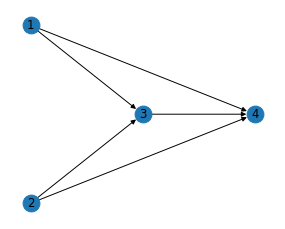

In [85]:
# Draw the nodes
plt.figure(figsize=(5,4), dpi=70)
nx.draw_networkx(G1, node_pos, arrows= True, with_labels=True)

#Remove the axis
plt.axis('off')
#Show the plot
plt.show()

In [86]:
# Determine all Origin-Destination pairs
origen = [1,2]
destination = [4,4]
demand = {(1,4): 2000 , (2,4): 1000}

In [87]:
# To solve the User Equilibrium, it is implemented the Frank-Wolfe for UE Formulation - Lecture 6
# Initialization
#Assign empty attributes
for i in G1.edges:
    G1.edges[i]["x0"] = 0.0
    G1.edges[i]["x1"] = 0.0
    G1.edges[i]["xn"] = 0.0
    G1.edges[i]["xn+1"] = 0.0
    G1.edges[i]["t1"] = 0.0    
    G1.edges[i]["tn"] = 0.0
    G1.edges[i]["yn"] = 0.0
    
# Shortest path 
path={}
for i in range(len(origen)):
    path[origen[i],destination[i]]=nx.dijkstra_path(G1,origen[i],destination[i])
#print(path)

# Determining the links in the shortest path
path2 = {}
for (i,j) in path.keys():
        path2[(i,j)] = []
        for k in range(len(path[(i,j)])-1):
            a = path[(i,j)][k]
            b = path[(i,j)][k+1]
            path2[(i,j)].append((a,b))
#path2

# All or nothing assignment
for (i,j) in path2.keys():
    for (k,l) in path2[(i,j)]:
        G1.edges[(k,l)]["x1"] += demand[(i,j)]

# Travel_time update
G1.edges[(1,3)]['t1'] = 0.5 + 0.001*G1.edges[(1,3)]['x1']
G1.edges[(2,3)]['t1'] = 0.5 + 0.001*G1.edges[(2,3)]['x1']
G1.edges[(1,4)]['t1'] = 1.0 + 0.0005*G1.edges[(1,4)]['x1']
G1.edges[(2,4)]['t1'] = 1.0 + 0.001*G1.edges[(2,4)]['x1']
G1.edges[(3,4)]['t1'] = 1.0 + 0.002*G1.edges[(3,4)]['x1']

#nx.get_edge_attributes(G1,"t1"), path, 
#nx.get_edge_attributes(G1,"x1")

In [88]:
for (i,j) in G1.edges:
    G1.edges[(i,j)]['tn'] = G1.edges[(i,j)]['t1']
for (i,j) in G1.edges:
    G1.edges[(i,j)]['xn'] = G1.edges[(i,j)]['x1']

In [89]:
#Code for the determination of xn+1
 
e = 0.0001
conv = 100
c = []

while conv > e:
    
    # Shortest path 
    pathn={}
    for i in range(len(origen)):
        pathn[origen[i],destination[i]]=nx.dijkstra_path(G1,origen[i],destination[i], weight = 'tn')
            
    # Determining the links in the shortest path
    path2n = {}
    for (i,j) in pathn.keys():
            path2n[(i,j)] = []
            for k in range(len(pathn[(i,j)])-1):
                a = pathn[(i,j)][k]
                b = pathn[(i,j)][k+1]
                path2n[(i,j)].append((a,b))
    
    # All or nothing assignment
    for (i,j) in path2n.keys():
        for (k,l) in path2n[(i,j)]:
            G1.edges[(k,l)]["yn"] += demand[(i,j)]
    #nx.get_edge_attributes(G1,"yn")
    
    # Function to optimize
    def fun_falpha(x):
        suma = 0.0
        for (i,j) in G1.edges:
            x_opt_13 = G1.edges[(1,3)]['xn']+x*(G1.edges[(1,3)]['yn']-G1.edges[(1,3)]['xn'])
            x_opt_23 = G1.edges[(2,3)]['xn']+x*(G1.edges[(2,3)]['yn']-G1.edges[(2,3)]['xn'])
            x_opt_14 = G1.edges[(1,4)]['xn']+x*(G1.edges[(1,4)]['yn']-G1.edges[(1,4)]['xn'])
            x_opt_24 = G1.edges[(2,4)]['xn']+x*(G1.edges[(2,4)]['yn']-G1.edges[(2,4)]['xn']) 
            x_opt_34 = G1.edges[(3,4)]['xn']+x*(G1.edges[(3,4)]['yn']-G1.edges[(3,4)]['xn']) 
            a = (G1.edges[(1,3)]['yn']-G1.edges[(1,3)]['xn'])*(0.5 + 0.001*x_opt_13)
            b = (G1.edges[(2,3)]['yn']-G1.edges[(2,3)]['xn'])*(0.5 + 0.001*x_opt_23)
            c = (G1.edges[(1,4)]['yn']-G1.edges[(1,4)]['xn'])*(1.0 + 0.0005*x_opt_14)
            d = (G1.edges[(2,4)]['yn']-G1.edges[(2,4)]['xn'])*(1.0 + 0.001*x_opt_24)            
            e = (G1.edges[(3,4)]['yn']-G1.edges[(3,4)]['xn'])*(1.0 + 0.002*x_opt_34)
            suma = a+b+c+d+e 
        return suma 
 
    # Optimization
    alpha = scipy.optimize.root(fun_falpha, 0.1, tol = 0.001)
    alp = alpha.x[0]
    #if alp>1:
     #   alp = 1
    #elif alp<0:
     #   alp=0
    #else:
     #   alp = alp
          
    #print(alp)
    
    # Update xn1
    for (i,j) in G1.edges:
        G1.edges[(i,j)]['xn+1']= G1.edges[(i,j)]['xn'] + alp*(G1.edges[(i,j)]['yn'] - G1.edges[(i,j)]['xn'])

    #nx.get_edge_attributes(G1,'xn+1')
    
    #Travel_time update
    G1.edges[(1,3)]['tn'] = 0.5 + 0.001*G1.edges[(1,3)]['xn+1']
    G1.edges[(2,3)]['tn'] = 0.5 + 0.001*G1.edges[(2,3)]['xn+1']
    G1.edges[(1,4)]['tn'] = 1.0 + 0.0005*G1.edges[(1,4)]['xn+1']
    G1.edges[(2,4)]['tn'] = 1.0 + 0.001*G1.edges[(2,4)]['xn+1']
    G1.edges[(3,4)]['tn'] = 1.0 + 0.002*G1.edges[(3,4)]['xn+1']

 
    # Convergence test
    sum1 = 0.0
    sum2 = 0.0
    for (i,j) in G1.edges:
        sum1 += ((G1.edges[(i,j)]['xn+1'] - G1.edges[(i,j)]['xn'])**2)**(1/2)
    for (i,j) in G1.edges:
        sum2 += G1.edges[(i,j)]['xn']
    conv = sum1/sum2
    c[len(c):] = [conv]
           
    #Re-start
    for (i,j) in G1.edges:
        G1.edges[(i,j)]['xn'] = G1.edges[(i,j)]['xn+1']
        G1.edges[(i,j)]['yn'] = 0.0
#nx.get_edge_attributes(G1,"xn+1")#, alp,     

In [90]:
#Total System Travel Time
T_UE = G1.edges[(1,3)]['xn+1']*(0.5+0.001*G1.edges[(1,3)]['xn+1']) + G1.edges[(2,3)]['xn+1']*(0.5+0.001*G1.edges[(2,3)]['xn+1']) + G1.edges[(1,4)]['xn+1']*(1.0+0.0005*G1.edges[(1,4)]['xn+1'])+G1.edges[(2,4)]['xn+1']*(1.0+0.001*G1.edges[(2,4)]['xn+1'])+G1.edges[(3,4)]['xn+1']*(1.0+0.002*G1.edges[(3,4)]['xn+1'])

In [91]:
# Links Time
UE_link_13 = nx.get_edge_attributes(G1,"tn")[(1,3)]
UE_link_23 = nx.get_edge_attributes(G1,"tn")[(2,3)]
UE_link_14 = nx.get_edge_attributes(G1,"tn")[(1,4)]
UE_link_24 = nx.get_edge_attributes(G1,"tn")[(2,4)]
UE_link_34 = nx.get_edge_attributes(G1,"tn")[(3,4)]


In [92]:
# Summary

xn_fin = nx.get_edge_attributes(G1,"xn+1")
tn = nx.get_edge_attributes(G1,"tn")

print('Total system travel time (minutes) = ', round(T_UE,2))
print('Link Time (1,3) = ', round(UE_link_13,3))
print('Link Time (2,3) = ', round(UE_link_23,3))
print('Link Time (1,4) = ', round(UE_link_14,3))
print('Link Time (2,4) = ', round(UE_link_24,3))
print('Link Time (3,4) = ', round(UE_link_34,3))


User_Equilibrium = pd.DataFrame.from_dict(xn_fin, orient='index', columns=['UE Link Total Flow (veh/hr)'])
User_Equilibrium

Total system travel time (minutes) =  5825.0
Link Time (1,3) =  0.6
Link Time (2,3) =  0.575
Link Time (1,4) =  1.95
Link Time (2,4) =  1.925
Link Time (3,4) =  1.35


,UE Link Total Flow (veh/hr)
"(1, 3)",100.113231
"(1, 4)",1899.886769
"(2, 3)",74.886679
"(2, 4)",925.113321
"(3, 4)",174.999910


This problem shows the flow assignment to the different links according to the User-Equilibrium Formulation, following the Frank Wolfe algorithm. 
The analysis continue with the Frank-Wolfe for SO notebook, where it shows the difference between both apporaches.
